In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
q = '''
SELECT
  DISTINCT chemical_code,
  chemical,
  para,
  month,
  chem_items,
  para_items
FROM (
  SELECT
    SUBSTR(bnf_code, 0, 9) AS chem_code_presc,
    month,
    SUM(items) AS chem_items
  FROM
    hscic.normalised_prescribing_standard
  GROUP BY
    chem_code_presc,
    month)
LEFT JOIN (
  SELECT
    SUBSTR(bnf_code, 0, 6) AS para_code,
    month AS para_month,
    SUM(items) AS para_items
  FROM
    hscic.normalised_prescribing_standard
  GROUP BY
    para_code,
    month)
ON
  SUBSTR(chem_code_presc, 0, 6) = para_code
  AND para_month = month
LEFT JOIN
  hscic.bnf
ON
  chemical_code = chem_code_presc
WHERE
  chemical_code IS NOT NULL
ORDER BY
  chemical_code,
  month
'''

chem_para_ratio = pd.read_gbq(q, dialect='standard', project_id = 'ebmdatalab')
chem_para_ratio.head()

,chemical_code,chemical,para,month,chem_items,para_items
0,210200001,DUMMY CHEMICAL SUBSTANCE 210200001,DUMMY PARAGRAPH 210200,2016-03-01,119,86571
1,210200001,DUMMY CHEMICAL SUBSTANCE 210200001,DUMMY PARAGRAPH 210200,2016-04-01,112,91439
2,210200001,DUMMY CHEMICAL SUBSTANCE 210200001,DUMMY PARAGRAPH 210200,2016-05-01,104,81017
3,210200001,DUMMY CHEMICAL SUBSTANCE 210200001,DUMMY PARAGRAPH 210200,2016-06-01,115,94983
4,210200001,DUMMY CHEMICAL SUBSTANCE 210200001,DUMMY PARAGRAPH 210200,2016-07-01,99,89618


In [116]:
chem_para = chem_para_ratio.copy()
chem_para = chem_para.sort_values(['chemical_code','month'])
chem_para['ratio'] = chem_para['chem_items'] / chem_para['para_items']
chem_para['chemical_code'] = 'ratio_quantity.' + chem_para['chemical_code'].astype(str)
#chem_para = chem_para.head(10000)
chem_para = chem_para.drop(['chemical','para'],axis=1)
chem_para = chem_para.set_index(['month','chemical_code'])

## drop small numbers
mask = (chem_para['chem_items'] > 50) & (chem_para['para_items']> 1000)
chem_para = chem_para.loc[mask]
chem_para = chem_para.drop(columns=['chem_items','para_items'])

## unstack
chem_para = chem_para.unstack().reset_index(col_level=1)
chem_para.columns = chem_para.columns.droplevel()
chem_para['month'] = pd.to_datetime(chem_para['month'])
chem_para = chem_para.set_index('month')

## fillna to replace those where numerator was 0
chem_para = chem_para.fillna(0)

## drop cols with all identical values
cols = chem_para.select_dtypes([np.number]).columns
std = chem_para[cols].std()
cols_to_drop = std[std==0].index
chem_para = chem_para.drop(cols_to_drop, axis=1)

## out to csv
chem_para.to_csv('data.pick.csv', index=False)
chem_para

chemical_code,ratio_quantity.0101010C0,ratio_quantity.0101010F0,ratio_quantity.0101010G0,ratio_quantity.0101010I0,ratio_quantity.0101010J0,ratio_quantity.0101010L0,ratio_quantity.0101010N0,ratio_quantity.0101010P0,ratio_quantity.0101010Q0,ratio_quantity.0101010R0,...,ratio_quantity.239448097,ratio_quantity.239448098,ratio_quantity.239448099,ratio_quantity.239448100,ratio_quantity.239601096,ratio_quantity.239601097,ratio_quantity.239601098,ratio_quantity.239607096,ratio_quantity.239610096,ratio_quantity.239610097
month,,,,,,,,,,,,,,,,,,,,,
2010-08-01,0.02713,0.00293,0.37644,0.01071,0.09255,0.15513,0.00000,0.06007,0.00581,0.24282,...,0.08769,0.06491,0.04408,0.00000,0.26283,0.72956,0.00000,0.00000,1.00000,0.00000
2010-09-01,0.02904,0.00278,0.37346,0.01041,0.09057,0.15273,0.00000,0.06202,0.00598,0.24313,...,0.08884,0.06174,0.04405,0.00000,0.21406,0.77284,0.00000,0.00000,1.00000,0.00000
2010-10-01,0.02641,0.00241,0.38041,0.01023,0.08968,0.15808,0.00000,0.06000,0.00651,0.23794,...,0.08894,0.06446,0.04428,0.00000,0.21609,0.77229,0.00000,0.00000,1.00000,0.00000
2010-11-01,0.02766,0.00259,0.37552,0.01167,0.09089,0.15371,0.00000,0.06212,0.00665,0.23851,...,0.09163,0.06135,0.04438,0.00000,0.23441,0.75135,0.00000,0.00000,1.00000,0.00000
2010-12-01,0.02784,0.00219,0.38552,0.01106,0.09699,0.16232,0.00000,0.06448,0.00586,0.21978,...,0.08209,0.05724,0.04058,0.00000,0.24874,0.73492,0.00000,0.00000,1.00000,0.00000
2011-01-01,0.02660,0.00280,0.37249,0.01243,0.09605,0.15621,0.00000,0.06183,0.00583,0.24425,...,0.08721,0.05999,0.04675,0.00000,0.22183,0.75924,0.00000,0.00000,1.00000,0.00000
2011-02-01,0.02736,0.00000,0.37210,0.01107,0.09331,0.15608,0.00000,0.05950,0.00625,0.25016,...,0.09062,0.06225,0.04652,0.00000,0.20776,0.76853,0.02371,0.00000,1.00000,0.00000
2011-03-01,0.02680,0.00273,0.36764,0.01014,0.09299,0.15742,0.00252,0.06000,0.00719,0.25120,...,0.08998,0.06021,0.04640,0.00000,0.20378,0.77576,0.02046,0.00000,1.00000,0.00000
2011-04-01,0.02839,0.00304,0.37290,0.01028,0.09227,0.16241,0.00265,0.06230,0.00715,0.23605,...,0.08640,0.06322,0.04428,0.00000,0.21058,0.76345,0.02597,0.00000,1.00000,0.00000


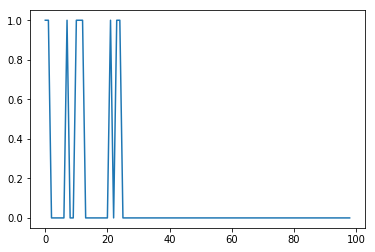

In [117]:
plt.plot(chem_para.reset_index()['ratio_quantity.200313000'])

In [75]:
from scipy.special import logit as logit
from scipy.special import expit as expit
chem_para['logit'] = logit(chem_para['ratio'])
chem_para['ratio2'] = expit(chem_para['logit'])
chem_para#.loc[(chem_para['ratio']==0)]

,,ratio,logit,ratio2
month,chemical_code,,,
2016-03-01,ratio_quantity.210200001,0.001375,-6.588221,0.001375
2016-04-01,ratio_quantity.210200001,0.001225,-6.703703,0.001225
2016-05-01,ratio_quantity.210200001,0.001284,-6.656739,0.001284
2016-06-01,ratio_quantity.210200001,0.001211,-6.715310,0.001211
2016-07-01,ratio_quantity.210200001,0.001105,-6.807086,0.001105
2016-08-01,ratio_quantity.210200001,0.001091,-6.819618,0.001091
2016-09-01,ratio_quantity.210200001,0.001022,-6.884770,0.001022
2016-10-01,ratio_quantity.210200001,0.000966,-6.941029,0.000966
2016-11-01,ratio_quantity.210200001,0.001122,-6.791232,0.001122


In [109]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
chem_para_ratio.describe()

,chem_items,para_items
count,225638.00000,225638.00000
mean,37840.09043,503889.28939
std,186159.98886,1062803.26746
min,1.00000,1.00000
25%,47.00000,2110.00000
50%,676.00000,58390.00000
75%,7712.00000,495065.00000
max,5996795.00000,6439718.00000
